# The final experiment: 
### A Multi-Layer Perceptron trained on embeddings of protein pocket sequences and ligand SMILES strings

Now, there exists a multitude of deep-learning based strategies taking advantage of embeddings. A transformer-type architecture could definitely make use of them, and in chemistry, there exists a plethora to choose from. However, we are firsst going to focus on the simplest deep learning architecture we can use as a baseline : the MLP.

To recap, so far we've :
- Trained a transformer to embed SMILES tokens based on masked modeling, then embedded all the ligand SMILES
- Used ESM2 to generate embeddings for the sequence tokens of our pockets
- For both the SMILES and the protein sequences, we mean-pooled the token embeddings to get per-sequence embeddings
- We concatenated both vectors for each protein-ligand complex to get final vectors of size 896

Now we're going to feed these vectors into an deep neural network with 3 hidden layers, using ReLU loss, and predicting a final single value for pKd, optimized via mean squared error.

In [2]:
from pathlib import Path

import torch
import torch.nn as nn
from torch import Tensor
from torch.utils.data import Dataset, DataLoader

from jaxtyping import Float64, Float32, jaxtyped
from beartype import beartype

import numpy as np
from numpy.typing import NDArray

import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
# Loading the preprocessed data from last notebook
DATA_DIR = "../data"
PDBBIND_DIR = Path(DATA_DIR, "v2015")
INTERIM_DIR = Path(DATA_DIR, "interim")
DATASET_PATH = Path(INTERIM_DIR, "reg_embeddings.npz")

data = np.load(DATASET_PATH)
X_train = data["arr_0"]
X_test = data["arr_1"]
y_train = data["arr_2"]
y_test = data["arr_3"]

In [ ]:
# Quick note: this time, I decided to use the jaxtyping library to type-check our tensors
# Since I am a clumsy programmer, I love type checkers and validation libraries
# jaxtyped gives type checking for both array data types and dimensions, via the LSP and optionally at runtime
class PDBBindEmbeddingDataset(Dataset):
    # The @jaxtyped decorator means that a type checker will actually validate this function at runtime
    # We will get an error if arrays aren't the right type or dimensions
    # Note that the first dimension is a variable : it can be whatever, but must be the same for both inputs
    @jaxtyped(typechecker=beartype)
    def __init__(
        self,
        embeddings: Float32[NDArray, "nsamples 1 896"],
        pkds: Float64[NDArray, "nsamples"]
    ) -> None:
        # We already preprocessed our data into numpy, so we just need to turn it into Tensors with Float32
        # embeddings was already set to Float32, but not pkds, and pytorch will throw errors if we don't correct it
        self.X = torch.from_numpy(embeddings)
        self.y = torch.from_numpy(pkds).float() 

    def __len__(self) -> int:
        return len(self.y)
 
    # We're not going to type-check at runtime here since we shouldn't need it
    # Note that X is a size 896 column vector, and y is a scalar
    def __getitem__(
        self, 
        idx:int
    ) -> tuple[Float32[Tensor, "896"], Float32[Tensor, ""]]:
        # Torch actually wants 1D vectors, so I'm squeezing it
        return self.X[idx].squeeze(1), self.y[idx]
        
train_dataset = PDBBindEmbeddingDataset(X_train, y_train)
test_dataset = PDBBindEmbeddingDataset(X_test, y_test)

batch_size=64

train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False)  # Don't shuffle test data

In [ ]:
# Boilerplate to run CUDA if it's available. I didn't use it here.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(torch.cuda.get_device_name(0) if device == 'cuda' else 'cpu')

cpu


In [ ]:
# A very simple neural network architecture with three hidden layers of decreasing size.
class PDBBindMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(896, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, x: Float32[Tensor, "896"]) -> Float32[Tensor, "batch"]:
        # Pass the input vector through the stack
        pred = self.linear_relu_stack(x)
        # Squeeze output from [batch, 1] to [batch]
        return pred.squeeze()


In [9]:
# Basic training loop
def train_loop(dataloader, model, loss_fn, optimizer):
    num_batches = len(dataloader)
    train_loss = 0
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    train_loss /= num_batches
    return train_loss

def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode, which disables droput layers and batch normalization
    model.eval()
    num_batches = len(dataloader)
    test_loss = 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    return test_loss


In [14]:
epochs = 300
learning_rate = 1e-3
model = PDBBindMLP()

optimizer = torch.optim.AdamW(model.parameters(), learning_rate)
loss_fn = nn.MSELoss()

train_losses = []
test_losses = []
print("Starting training...")
with tqdm(range(epochs), desc="Training") as pbar:
    for t in pbar:
        train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
        test_loss = test_loop(test_dataloader, model, loss_fn)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        pbar.set_postfix(test_loss=test_loss, train_loss=train_loss)

print("Done!")

Starting training...


Training: 100%|██████████| 300/300 [06:36<00:00,  1.32s/it, test_loss=0.197, train_loss=0.007]  

Done!


### We can see that our model is severly overfitting

This might be expected given the size of the neural network vs. our dataset. Our test loss actually gets worse with time, which is a telltale signal.

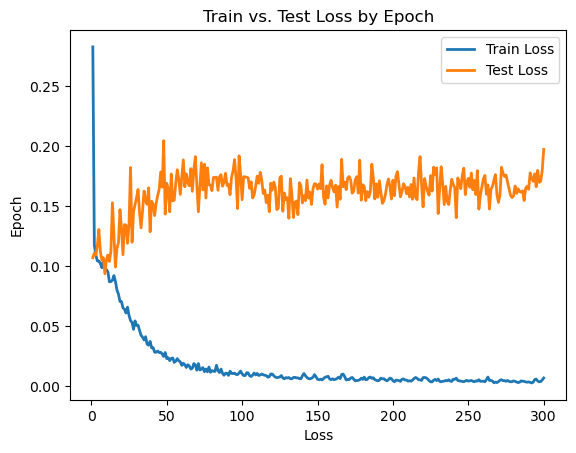

In [ ]:
epochs = range(1, len(train_losses) + 1)

# Plotting loss by epoch
fig, ax = plt.subplots()
ax.plot(epochs, train_losses, label="Train Loss", linewidth=2)
ax.plot(epochs, test_losses, label="Test Loss", linewidth=2)
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Train vs. Test Loss by Epoch')

plt.show()

In [ ]:
class PDBBindMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(896, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, x: Float32[Tensor, "896"]) -> Float32[Tensor, "batch"]:
        # Pass the input vector through the stack
        pred = self.linear_relu_stack(x)
        # Squeeze output from [batch, 1] to [batch]
        return pred.squeeze()


In [ ]:
epochs = 300
learning_rate = 1e-3
model = PDBBindMLP()

optimizer = torch.optim.AdamW(model.parameters(), learning_rate)
loss_fn = nn.MSELoss()

train_losses = []
test_losses = []
print("Starting training...")
with tqdm(range(epochs), desc="Training") as pbar:
    for t in pbar:
        train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
        test_loss = test_loop(test_dataloader, model, loss_fn)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        pbar.set_postfix(test_loss=test_loss, train_loss=train_loss)

print("Done!")

Starting training...


Training: 100%|██████████| 300/300 [06:40<00:00,  1.34s/it, test_loss=0.0854, train_loss=0.0151]

Done!


### Adding some dropout layers makes the test loss at least not get worse with time. 
However, the model doesn't seem to actually be learning anything meaningful. Maybe making it a lot smaller will force it to focus on what's essential ?

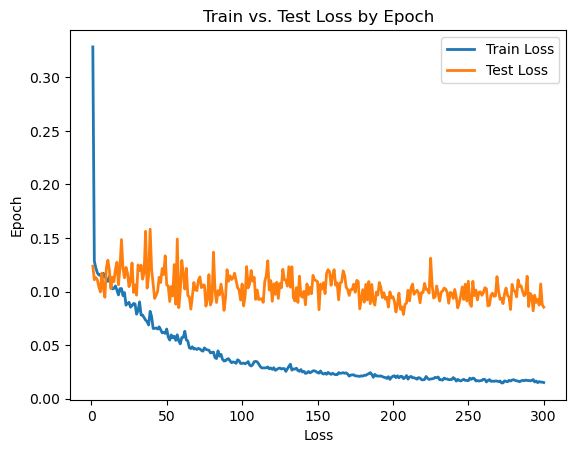

In [ ]:
epochs = range(1, len(train_losses) + 1)

# Plotting loss by epoch
fig, ax = plt.subplots()
ax.plot(epochs, train_losses, label="Train Loss", linewidth=2)
ax.plot(epochs, test_losses, label="Test Loss", linewidth=2)
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Train vs. Test Loss by Epoch')

plt.show()

In [8]:
class PDBBindMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(896, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x: Float32[Tensor, "896"]) -> Float32[Tensor, "batch"]:
        # Pass the input vector through the stack
        pred = self.linear_relu_stack(x)
        # Squeeze output from [batch, 1] to [batch]
        return pred.squeeze()


In [17]:
epochs = 600
learning_rate = 1e-5
model = PDBBindMLP()

optimizer = torch.optim.AdamW(model.parameters(), learning_rate)
loss_fn = nn.MSELoss()

train_losses = []
test_losses = []
print("Starting training...")
with tqdm(range(epochs), desc="Training") as pbar:
    for t in pbar:
        train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
        test_loss = test_loop(test_dataloader, model, loss_fn)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        pbar.set_postfix(test_loss=test_loss, train_loss=train_loss)

print("Done!")

Starting training...


Training: 100%|██████████| 600/600 [05:19<00:00,  1.88it/s, test_loss=0.11, train_loss=0.0329] 

Done!


### Verdict: I'm not too sure where to go on from here

I tried making a smaller neural network to see if it would overfit less. I also tried reducing the learning rate and incerasing the number of epochs to get a smoother curve. It doesn't seem like the neural network is learning anything useful so far, as seen from the ever-increasing test loss.

Note that if we compare to the previous XGBoost-based method, we managed to get our RMSE down to about 0.06, while here, it's around 0.3. While not perfect, it's still not completely off. But to find a method that can actually outperform our baseline, we might have to dig deeper into the representations that we are utilizing.

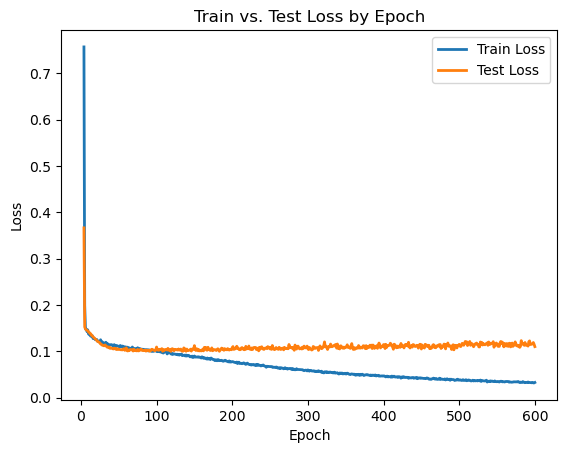

In [21]:
epochs = range(1, len(train_losses) + 1)

# Plotting loss by epoch
fig, ax = plt.subplots()
ax.plot(epochs[3:], train_losses[3:], label="Train Loss", linewidth=2)
ax.plot(epochs[3:], test_losses[3:], label="Test Loss", linewidth=2)
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Train vs. Test Loss by Epoch')

plt.show()